**Part 1- Neural Network**

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import matplotlib.pyplot as plt
import keras.datasets.fashion_mnist as fashion_mnist

4422102/4422102 [==============================] - 1s 0us/step


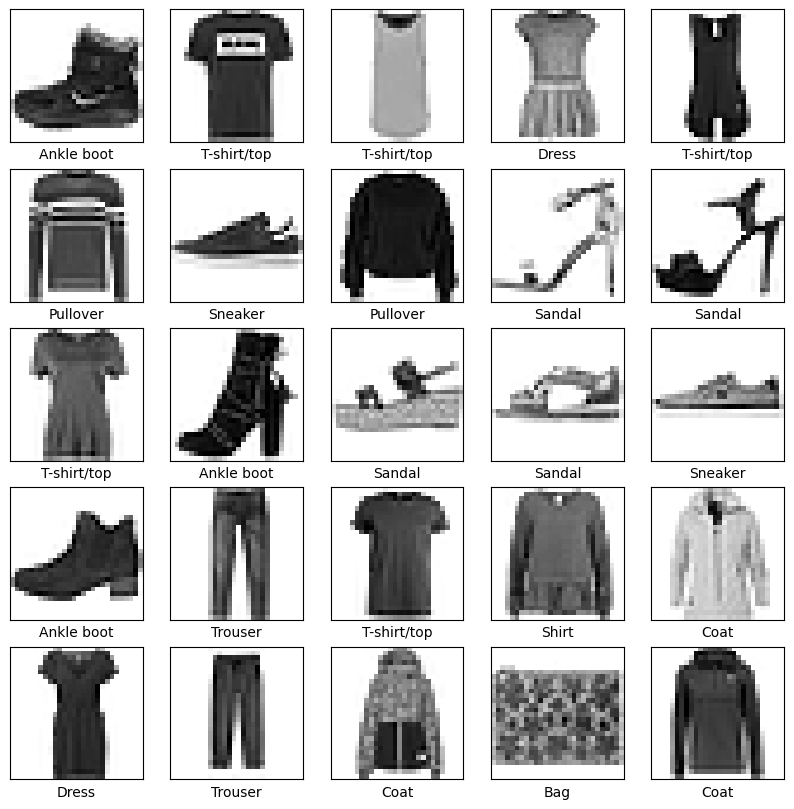

In [3]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# plot 4 images as gray scale
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

In [4]:
# flatten 28*28 images to a 784 vector for each image
IMG_HEIGHT=28
IMG_WIDTH= 28
channels =1

In [5]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

In [6]:
#Create the model here
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model = tf.keras.Sequential([
                             tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH)),
                             tf.keras.layers.Dense(128, activation= 'relu'),
                             tf.keras.layers.Dense(10, activation= 'softmax')])
# Using softmax for output activation function since it's multi class

model.compile(optimizer='adam', loss= loss_fn, metrics=['accuracy'])

In [ ]:
# Train the model here
hist = model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=128)

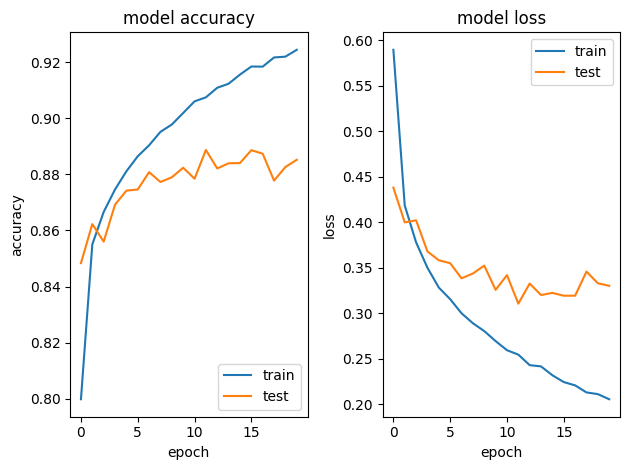

In [11]:
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

plt.show()

The model has a high accuracy at .8 initially and .92 as it learns. The test set seems to slightly improve accuracy but the changes in direction shows that it the model may be overfitting.

The loss is initially is a lot at .6, but decreases with training. After the first 5 epochs it looks like the model learns the best and I would recommend decreasing the training epochs.

**Part 2- Image Processing**

Load the Flower photo dataset from tensorflow repository

In [ ]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

*a) How many images we can find in this dataset?*




In [17]:
image_count = len(list(data_dir.glob('*/*.jpg')))  #This will count all the file with extension of jpg- You have to modify this part
print("Image count inside data_dir:", image_count)

Image count inside data_dir: 3670


*b) The list of subfolders are:*
*   daisy
*   dandelion
*   roses
*   sunflowers
*   tulips

You can look into any of the subfolders to see images stored over there. You can look into the folder using: data_dir.glob('tulips/*')
For this part use Pillow (PIL) to show at least one flower from each subfolder


Flower type:  dandelion


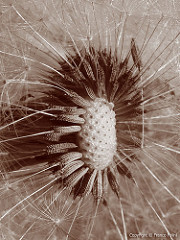

Flower type:  daisy


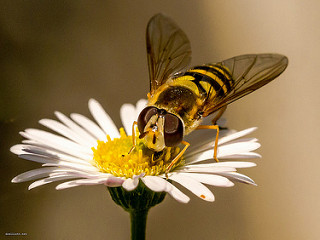

Flower type:  roses


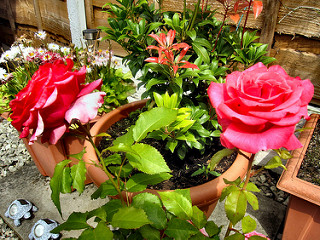

Flower type:  tulips


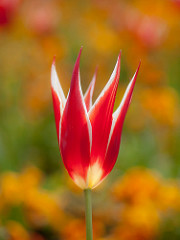

Flower type:  sunflowers


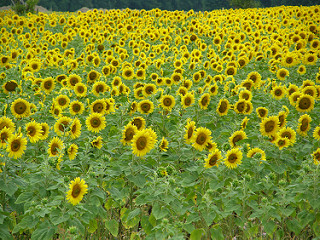

In [18]:
dataset_images = {'dandelion':[], 'daisy': [], 'roses': [], 'tulips':[], 'sunflowers': []}
for sub_dir in data_dir.glob('*/'):
    if sub_dir.is_dir():
      dir_name = sub_dir.name
      # Iterate over image files in the subdirectory
      for image_path in sub_dir.glob('*.jpg'):

          # Append the image path to the list
        dataset_images[dir_name].append(image_path)

for key in dataset_images.keys():
  img = PIL.Image.open(dataset_images[key][2])
  print("Flower type: ", key)
  display(img)

*c) Use Keras to resize all the images into same dimension 180x180*

In [19]:
batch_size = 32
img_height = 180
img_width = 180

In [24]:
# Convert all the images in data_dir folder into 180x180 using tf.kera.utils.image_dataset_from_directory
# Modify following code
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir, labels='inferred', image_size=(180,180), validation_split=0.2, subset="training", seed=58)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [25]:
# Use the same strategy to create validation data, this time from validation subset
val_ds = tf.keras.utils.image_dataset_from_directory(data_dir, labels='inferred', image_size=(180,180), validation_split=0.2, subset="validation", seed=58)


Found 3670 files belonging to 5 classes.
Using 734 files for validation.


d) *You can use* `train_ds.class_names` *command to get the list of labels. Write a code to randomly show 9 images from training data while printing their label on top of the image.*

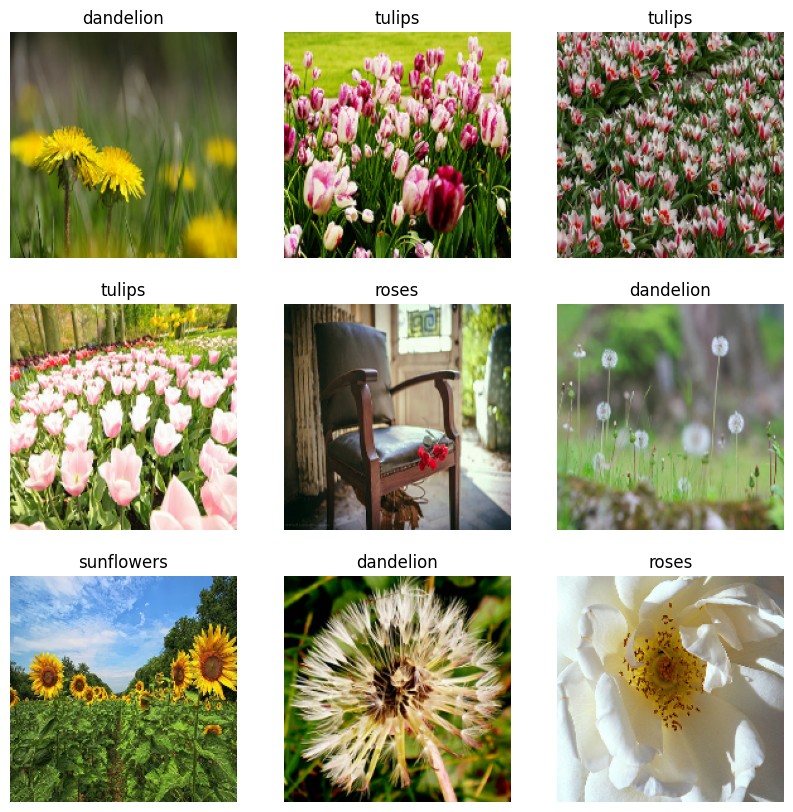

In [40]:
def display_img(train_ds):
  class_names = train_ds.class_names
  plt.figure(figsize=(10, 10))
  for images, labels in train_ds.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      image_np = np.array(images[i], dtype=np.float32) / 255.0 # converting to numpy and scaling values
      plt.imshow(image_np)   # Needed to use a converted image
      plt.title(class_names[labels[i]])
      plt.axis("off")

display_img(train_ds)

In [31]:
# Please carefully review the images. What are some barriers that you can see in images for having a proper classification?

Some of the barriers that stick out to me is the contrast in different backgrounds. Colored natural background vs black background. The zoom, focus, and angle is also not consistant with all the photos. One photo also consists of a human holding a flower. Having so much variety impacts how the model is trained and how accurately the model classifies photos.

*e* - *Now, we want to use preprocessing package in Keras to apply different filters to the image. Apply the following procedures to image data:*
- *Rescale the image by dividing by 255*
- *Shear the image 20%*
- *Zoom the image 20%*
- *Horizontally flip the images*

In [42]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Convert the TensorFlow dataset to NumPy arrays
train_images = []
train_labels = []

for images, labels in train_ds:
    train_images.append(images.numpy())
    train_labels.append(labels.numpy())

train_images = np.vstack(train_images)
train_labels = np.concatenate(train_labels)
training_set = train_datagen.flow(train_images, train_labels, batch_size=batch_size, shuffle=True)
# training_set = train_datagen.flow_from_directory()   # Modify this line of code


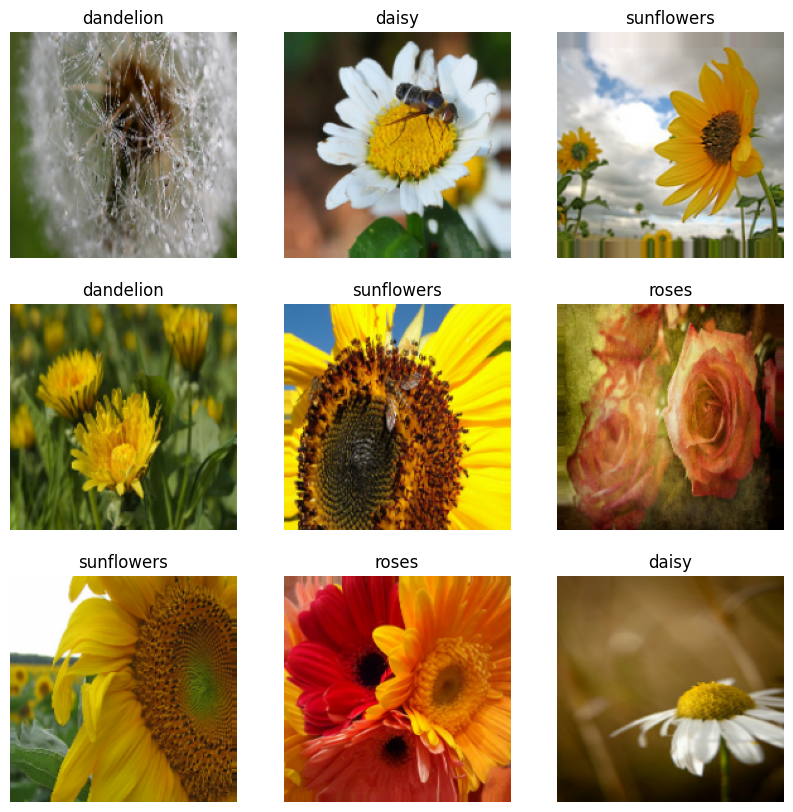

In [57]:
images, labels = next(training_set)

# Create a figure and plot the images in a grid
plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[int(labels[i])] if class_names else f"Class {int(labels[i])}")
    plt.axis("off")

plt.show()

**Part 3- OPENCV**- Now use opencv for preprocessing. Show first 9 images in dataset using Opencv. Before showing each image, resize the images to 180x180.

<Figure size 1000x1000 with 0 Axes>

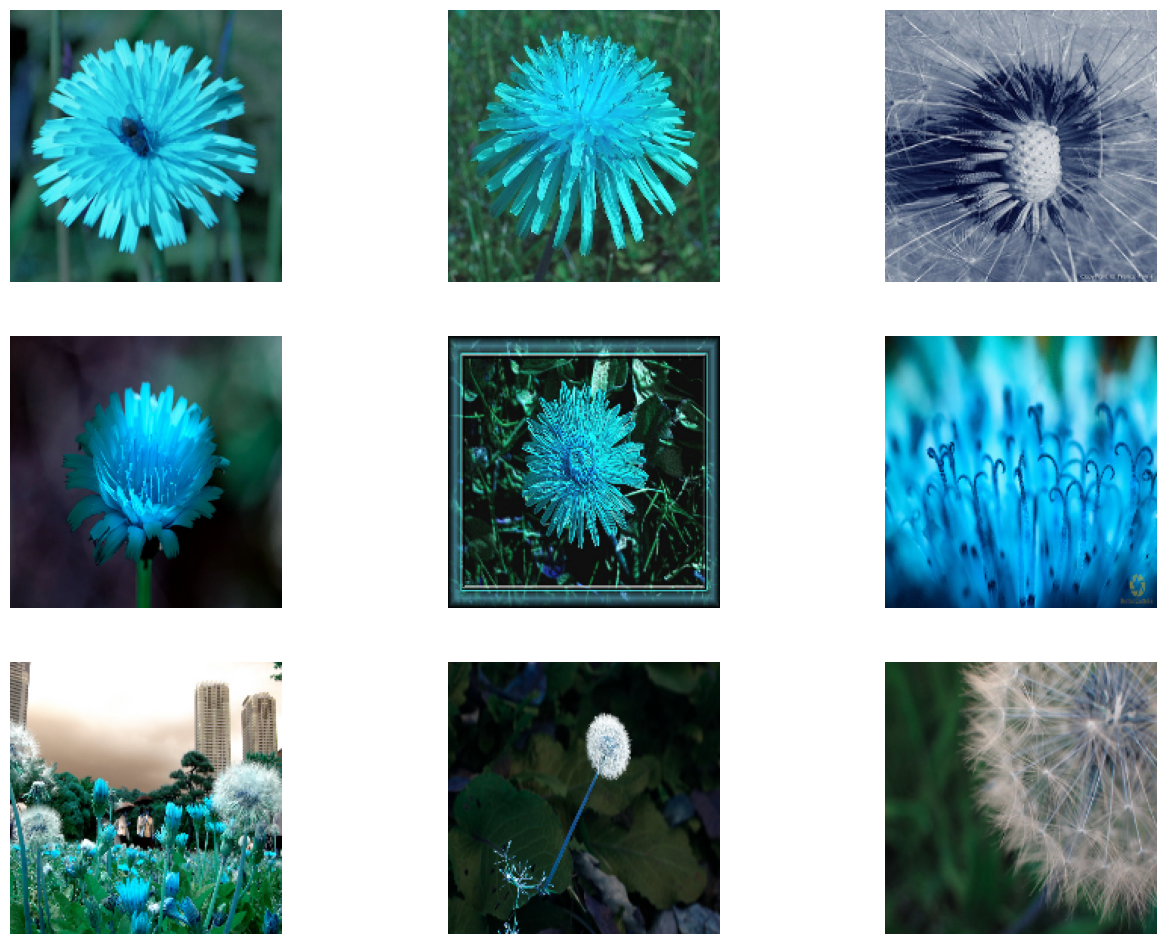

In [56]:
# Repeat same preprocessing but this time using OpenCV. Show first 9 images in dataset using Opencv. Before showing each image, resize the images to 180x180.
import cv2
list_of_images= list(data_dir.glob('*/*.jpg'))
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
fig=plt.figure(figsize=(16, 12))

for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  # loading image
  image = cv2.imread(str(list_of_images[i]))
  # Resizing image
  resized = cv2.resize(image, (180, 180))
  plt.imshow(resized)
  plt.axis("off")

plt.show()


OpenCV uses BGR as its default colour order for images, matplotlib uses RGB. When you display an image loaded with OpenCv in matplotlib the channels will be back to front.
The easiest way of fixing this is to use OpenCV to explicitly convert it back to RGB, much like you do when creating the greyscale image.
`RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)`

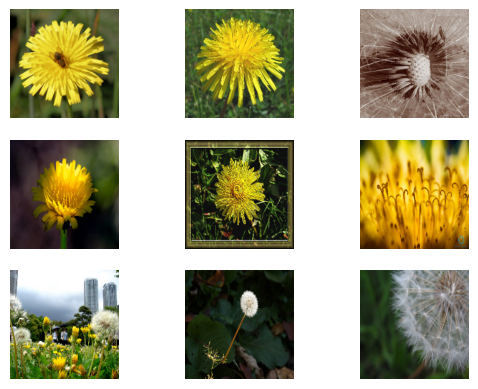

In [54]:
# Add the code here to create the output

for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  image = cv2.imread(str(list_of_images[i]))
  resized = cv2.resize(image, (180, 180))
  RGB_img = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
  plt.imshow(RGB_img)
  plt.axis("off")

plt.show()